In [10]:
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets

import scienceplots
plt.style.use(['science', 'no-latex'])

# add src to path
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..', 'src')))
from non_linear_4_pop import response, determinant, dynamics, transfer_function, ext_input, ext_input_const, ss_gain, response_regime_metric, ee_cross_diff, plot_cross_ee

In [ ]:
# def response(W, B, dI):
#     """
#     W : weight matrix
#     I : input (dI)
#     B: diagonal matrix of cellular gains
#     """

#     if np.linalg.det(B) == 0:
#         # print("Matrix B is singular, cannot compute its inverse.")
#         return np.nan, np.nan
    
#     A = np.linalg.inv(B) - W

#     if np.linalg.det(A) == 0:
#         # print("Matrix A is singular, cannot compute its inverse.")
#         return np.nan, np.nan
#     R = np.linalg.inv(A)
    
#     R_l = R[0] @ dI
#     R_e = R[1] @ dI

#     return R_l, R_e

# def determinant(W, B):
#     """
#     Compute the determinant of the matrix A = inv(B) - W
#     where B is the diagonal matrix of cellular gains
#     and W is the weight matrix
    
#     This determinant is the denominator of the response functions
#     """
#     if np.linalg.det(B) == 0:
#         # print("Matrix B is singular, cannot compute its inverse.")
#         return np.nan
#     A = np.linalg.inv(B) - W
#     det = np.linalg.det(A)
#     return det

# def dynamics(W, I, tau=np.ones(4), dt=0.01, duration=5):
#     """
#     Compute the dynamics of the system given by:
#     dR/dt = -R + f(WR + I)
#     where f is the linear transfer function with gain B
#     """

#     r = np.zeros((W.shape[0], int(duration/dt)))

#     for t in range(1, r.shape[1]):
#         r[:, t] = r[:, t-1] + (dt/tau) * (-r[:, t-1] + transfer_function(W @ r[:, t-1] + I))

#     return r

# def transfer_function(input):
#     output = (1/4) * input**2
#     return output

# def ext_input(bg_l, bg_e, bg_p, bg_c, duration, dt, t_on, amp, tau_l, tau_e, tau_p, tau_c):
#     """
#     create the external input vector as a numpy array
#     where at specified time, the input increases from baseline to a higher value
#     in an exponentially decaying manner
#     """

#     n_steps = int(duration/dt)
#     t_on = int(t_on/dt)
#     I = np.zeros((4, int(duration/dt)))

#     for t in range(n_steps):
#         if t >= t_on:
#             I[0, t] = bg_l + amp * (1 - np.exp(-(t - t_on)/tau_l))
#             I[1, t] = bg_e + amp * (1 - np.exp(-(t - t_on)/tau_e))
#             I[2, t] = bg_p + amp * (1 - np.exp(-(t - t_on)/tau_p))
#             I[3, t] = bg_c + amp * (1 - np.exp(-(t - t_on)/tau_c))
#         else:
#             I[0, t] = bg_l
#             I[1, t] = bg_e
#             I[2, t] = bg_p
#             I[3, t] = bg_c

#     return I

# def ext_input_const(bg_l=1, bg_e=1, bg_p=1, bg_c=1):
#     """
#     create the external input vector as a numpy array
#     where the input is constant
#     """

#     I = np.array([bg_l, bg_e, bg_p, bg_c], dtype=float)

#     return I

# def ss_gain(W, r_ss, I):
#     """
#     Compute the steady state gain of the system
#     given the weight matrix W and the steady state rates r, and the input to the system I

#     assumes that the transfer function = f(input) = (input^2)/4
#     """
#     B_ss = np.diag((W @ r_ss + I)/2)
#     return B_ss

# def response_regime_metric(R_l, R_e):
#     """
#     Compute the response regime metric
#     defined as the ratio of the change in R_e to the change in R_l
#     """

#     if R_l > 0 and R_e > 0: # training
#         return 0
#     elif R_l > 0 and R_e <= 0: # early recall
#         return 1
#     elif R_l <= 0 and R_e > 0: # late recall
#         return 2
#     else: # no response
#         return 3

In [3]:
def ee_cross_diff(J, g_p, g_c, alpha, beta, I_l, I_e, I_p, I_c):

    W = np.array([[J, beta*J, -g_p*J, -g_c*J],
                   [alpha*J, J, -g_p*J, -g_c*J],
                   [J, J, -g_p*J, -g_c*J],
                   [J, J, -g_p*J, -g_c*J]])
    # simulate dynamics
    input = ext_input_const()
    r = dynamics(W, input)
    r_ss = r[:, -1]
    # infer the steady state gain
    B = ss_gain(W, r_ss, input)

    # compute the response functions
    dI = np.array([I_l, I_e, I_p, I_c])
    R_l, R_e = response(W, B, dI)
    det = determinant(W, B)

    return R_l, R_e, det


In [4]:
def plot_cross_ee(J, g_p, g_c, I_l, I_e, I_p, I_c, vmin, vmax, savefig=False, location=""):
    
    alpha_arr = np.linspace(0.1, 5.0, 100)
    beta_arr = np.linspace(0.1, 5.0, 100)

    R_l = np.zeros((len(alpha_arr), len(beta_arr)))
    R_e = np.zeros((len(alpha_arr), len(beta_arr)))
    determinant_grid = np.zeros((len(alpha_arr), len(beta_arr)))
    response_regime = np.zeros((len(alpha_arr), len(beta_arr)))

    for i, alpha in enumerate(alpha_arr):
        for j, beta in enumerate(beta_arr):
            R_l[i, j], R_e[i, j], determinant_grid[i, j] = ee_cross_diff(J, g_p, g_c, alpha, beta, I_l, I_e, I_p, I_c)
            response_regime[i, j] = response_regime_metric(R_l[i, j], R_e[i, j])

    fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi=200)

    im1 = ax[0].imshow(determinant_grid.T, extent=(alpha_arr.min(), alpha_arr.max(), beta_arr.min(), beta_arr.max()), origin='lower', aspect='auto')
    ax[0].set_title('Determinant')
    ax[0].set_xlabel(r'$\alpha$')
    ax[0].set_ylabel(r'$\beta$')
    fig.colorbar(im1, ax=ax[0])
    # add dashed white line at determinant = 0
    cx = ax[0].contour(alpha_arr, beta_arr, determinant_grid.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt='%.2f', inline=True, fontsize=8)

    im2 = ax[1].imshow(R_l.T, extent=(alpha_arr.min(), alpha_arr.max(), beta_arr.min(), beta_arr.max()), origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    ax[1].set_title('R_l')
    ax[1].set_xlabel(r'$\alpha$')
    ax[1].set_ylabel(r'$\beta$')
    fig.colorbar(im2, ax=ax[1])
    cx = ax[1].contour(alpha_arr, beta_arr, R_l.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt='%.2f', inline=True, fontsize=8)

    im3 = ax[2].imshow(R_e.T, extent=(alpha_arr.min(), alpha_arr.max(), beta_arr.min(), beta_arr.max()), origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    ax[2].set_title('R_e')
    ax[2].set_xlabel(r'$\alpha$')
    ax[2].set_ylabel(r'$\beta$')
    fig.colorbar(im3, ax=ax[2])
    cx = ax[2].contour(alpha_arr, beta_arr, R_e.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt='%.2f', inline=True, fontsize=8)

    im4 = ax[3].imshow(response_regime.T, extent=(alpha_arr.min(), alpha_arr.max(), beta_arr.min(), beta_arr.max()), origin='lower', aspect='auto')
    ax[3].set_title('Response Regime')
    ax[3].set_xlabel(r'$\alpha$')
    ax[3].set_ylabel(r'$\beta$')
    cbar = fig.colorbar(im4, ax=ax[3], ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['Training', 'Early Recall', 'Late Recall', 'No Response']) 

    fig.suptitle('Excitatory cross connections')
    fig.tight_layout()

    if savefig:
        plt.savefig(location + "cross_ee.svg")
    plt.show()

    # plt.figure(figsize=(6, 5), dpi=200)
    # plt.imshow(response_regime.T, extent=(alpha_arr.min(), alpha_arr.max(), beta_arr.min(), beta_arr.max()), origin='lower', aspect='auto')
    # plt.title('Response Regime')
    # plt.xlabel(r'$\alpha$')
    # plt.ylabel(r'$\beta$')
    # plt.colorbar(ticks=[0, 1, 2, 3], labels=['Training', 'Early Recall', 'Late Recall', 'No Response'])
    # plt.show()
    
    return response_regime

In [ ]:
@widgets.interact(J = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1),
                  g_p = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1),
                  g_c = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1),
                  I_l = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1),
                  I_e = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1),
                  I_p = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1),
                  I_c = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1), 
                  vmin = widgets.FloatSlider(value=-5.0, min=-10.0, max=0.0, step=0.1),
                  vmax = widgets.FloatSlider(value=5.0, min=0.0, max=10.0, step=0.1))
def explore_solution_spaces(J, g_p, g_c, I_l, I_e, I_p, I_c, vmin, vmax):
    plot_cross_ee(J, g_p, g_c, I_l, I_e, I_p, I_c, vmin, vmax)

interactive(children=(FloatSlider(value=1.0, description='J', max=5.0, min=0.1), FloatSlider(value=1.0, descri…

/var/folders/g6/7nyb4bzj60n8q754q7qp7z200000gn/T/ipykernel_46111/2937297992.py:55: RuntimeWarning: overflow encountered in square
  output = (1/4) * input**2
/var/folders/g6/7nyb4bzj60n8q754q7qp7z200000gn/T/ipykernel_46111/2937297992.py:100: RuntimeWarning: invalid value encountered in matmul
  B_ss = np.diag((W @ r_ss + I)/2)
/var/folders/g6/7nyb4bzj60n8q754q7qp7z200000gn/T/ipykernel_46111/2937297992.py:49: RuntimeWarning: invalid value encountered in matmul
  r[:, t] = r[:, t-1] + (dt/tau) * (-r[:, t-1] + transfer_function(W @ r[:, t-1] + I))
/Users/divyansh/miniforge3/envs/mean_field/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2430: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/var/folders/g6/7nyb4bzj60n8q754q7qp7z200000gn/T/ipykernel_46111/2937297992.py:49: RuntimeWarning: invalid value encountered in add
  r[:, t] = r[:, t-1] + (dt/tau) * (-r[:, t-1] + transfer_function(W @ r[:, t-1] + I))


<Figure size 350x262.5 with 0 Axes>

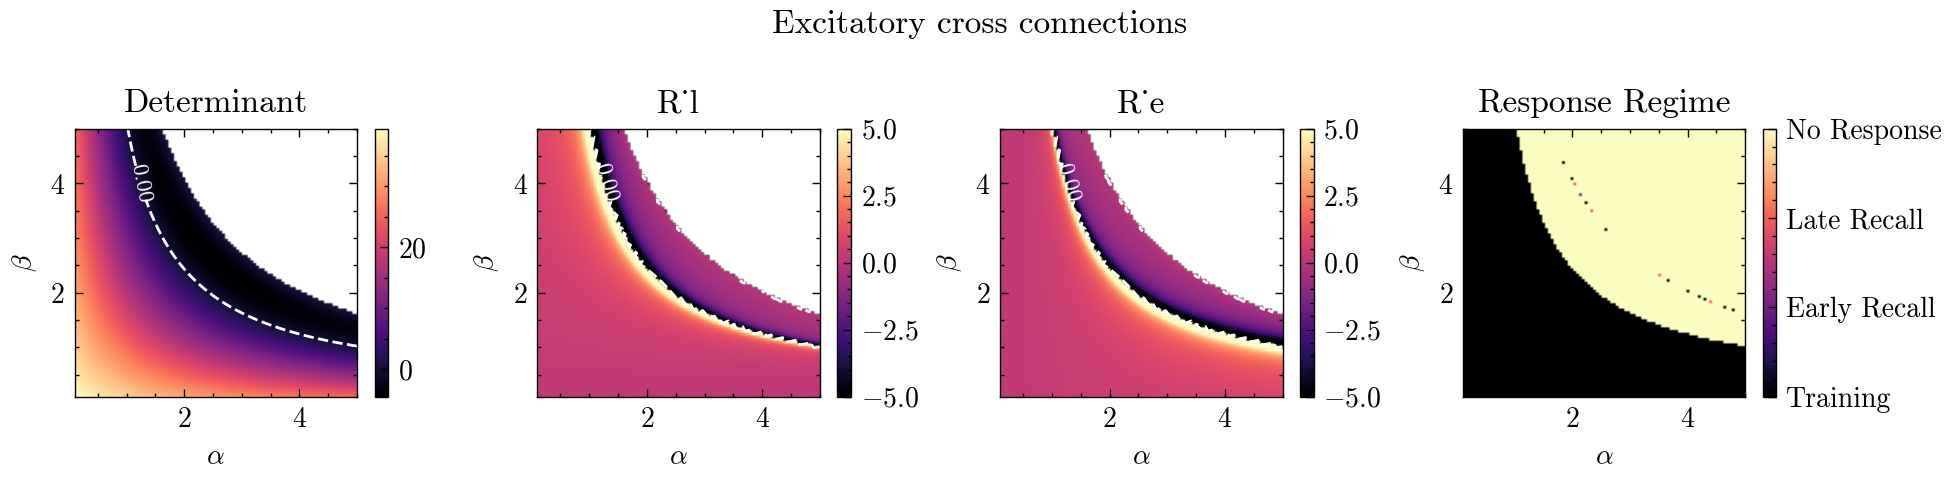

TypeError: Colorbar.__init__() got an unexpected keyword argument 'labels'. Did you mean 'label'?

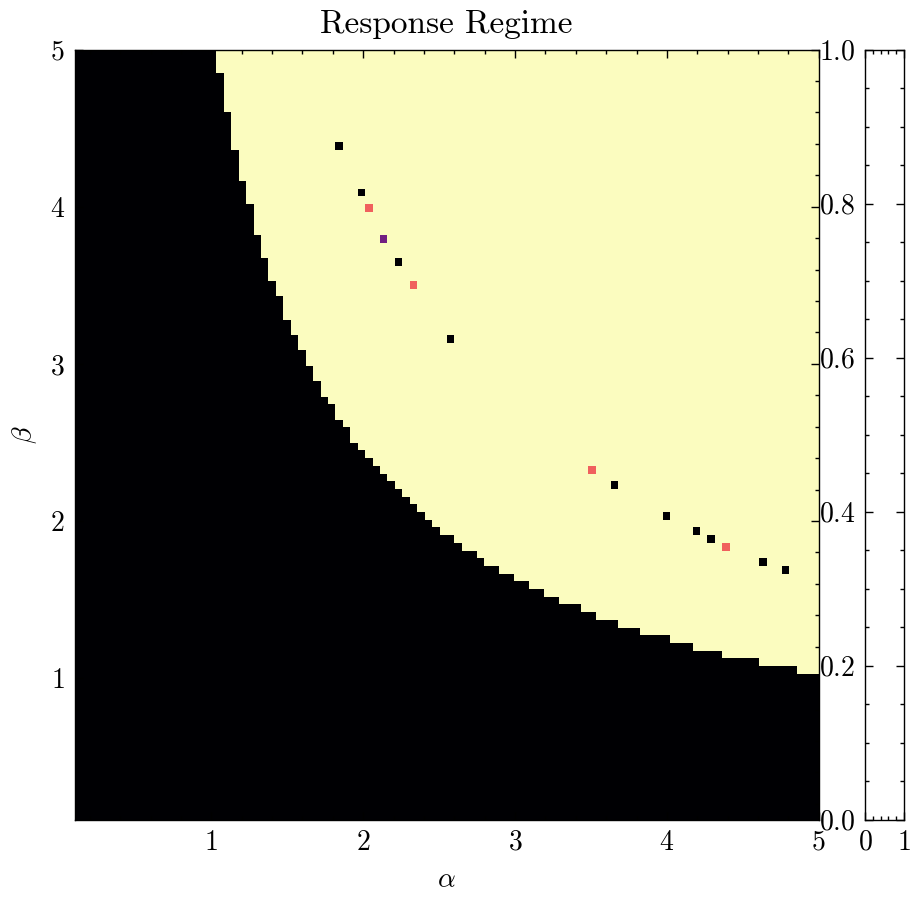

In [ ]:
# set colormap
plt.set_cmap('magma')
J = 0.6
g_p = 1.3
g_c = 1.3
I_l = 1
I_e = 1
I_p = 1
I_c = 1
vmin = -5
vmax = 5

response_regime = plot_cross_ee(J, g_p, g_c, I_l, I_e, I_p, I_c, vmin, vmax, savefig=True, location="../../results/4_pop_non-linear/cross_ee/") 

In [49]:
def dynamics_plot(J, g_p, g_c, alpha, beta, I_l, I_e, I_p, I_c, duration=10, dt=0.01, savefig=False, location="", label=""):
    W = np.array([[J, beta*J, -g_p*J, -g_c*J],
                   [alpha*J, J, -g_p*J, -g_c*J],
                   [J, J, -g_p*J, -g_c*J],
                   [J, J, -g_p*J, -g_c*J]])

    tau = 0.01*np.ones(4)

    r = np.zeros((W.shape[0], int(duration/dt)))
    input = ext_input(I_l, I_e, I_p, I_c, duration=duration, dt=dt, t_on=5, amp=0.1, tau_l=5, tau_e=5, tau_p=5, tau_c=5)

    for t in range(1, r.shape[1]):

        r[:, t] = r[:, t-1] + (dt/tau) * (-r[:, t-1] + transfer_function(W @ r[:, t-1] + input[:, t]))


    time = np.arange(0, duration, dt)
    skip = 10
    time = time[skip:]
    r = r[:, skip:]
    plt.figure(figsize=(3, 1.5), dpi=300)
    plt.plot(time, r[0], label='R_l', color='blue')
    plt.plot(time, r[1], label='R_e', color='orange')
    # plt.plot(time, r[2], label='R_p', color='green')
    # plt.plot(time, r[3], label='R_c', color='red')
    plt.xlabel('Time (s)')
    plt.ylabel('Firing Rate (Hz)')
    plt.title('Dynamics')
    plt.legend()

    plt.savefig(location + "dynamics" + label + ".svg")
    plt.show()

    # # plot the input
    # plt.figure(figsize=(3, 1.5), dpi=300)
    # plt.plot(time, input[0], label='I_l', color='blue')
    # plt.plot(time, input[1], label='I_e', color='orange')
    # plt.plot(time, input[2], label='I_p', color='green')
    # plt.plot(time, input[3], label='I_c', color='red')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Input (a.u.)')
    # plt.title('External Input')
    # plt.legend()
    # plt.show()

In [61]:
# remove ticks from the plots
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False

# set font size
plt.rcParams.update({'font.size': 12})
# set linewdith
plt.rcParams['lines.linewidth'] = 2

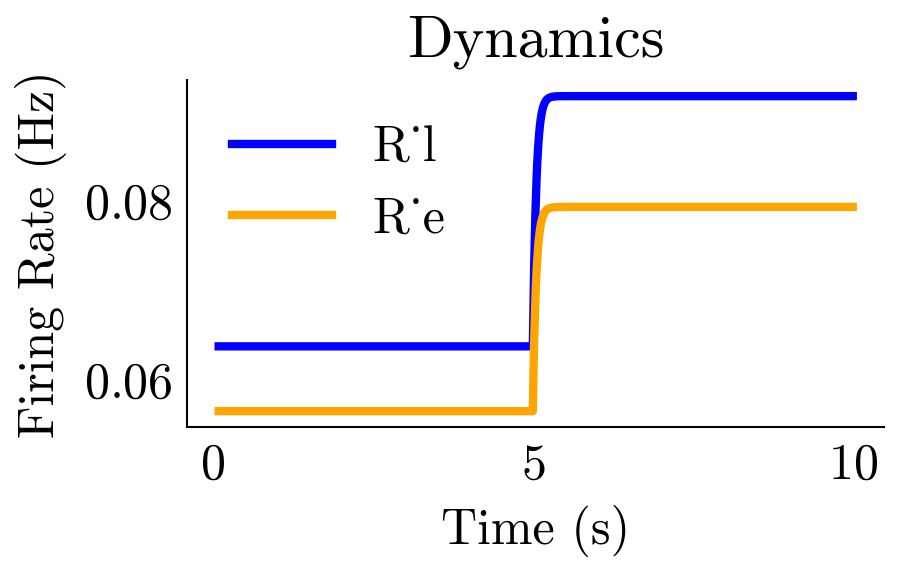

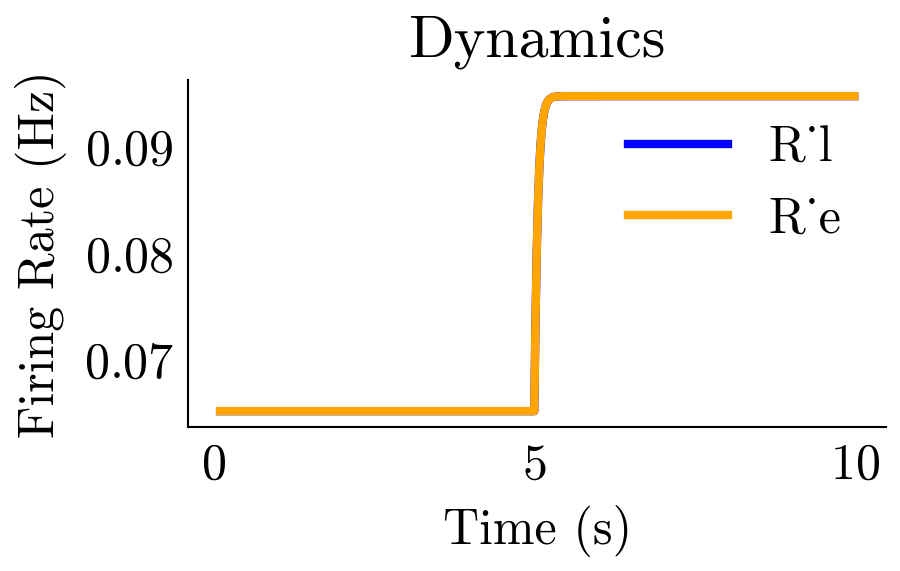

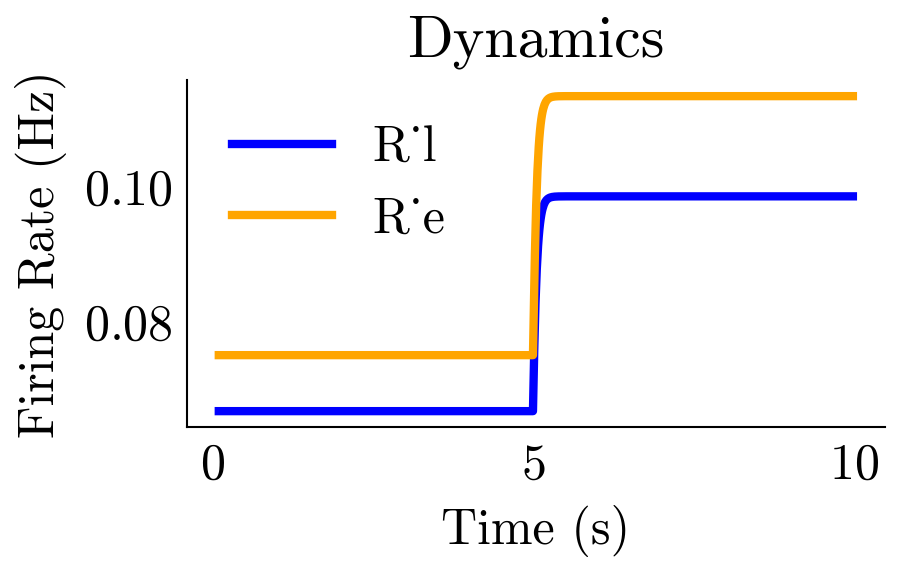

In [62]:
J = 0.6
g_p = 1
g_c = 1
alpha = 0.4
beta = 1.2
I_l = 0.5
I_e = 0.5
I_p = 0.5
I_c = 0.5

dynamics_plot(J, g_p, g_c, alpha=alpha, beta=beta, I_l=I_l, I_e=I_e, I_p=I_p, I_c=I_c, duration=10, dt=0.01, savefig=True, location="../../results/4_pop_non-linear/cross_ee/", label=f"alpha={alpha}_beta={beta}")

J = 0.6
g_p = 1
g_c = 1
alpha = 1.2
beta = 1.2
I_l = 0.5
I_e = 0.5
I_p = 0.5
I_c = 0.5

dynamics_plot(J, g_p, g_c, alpha=alpha, beta=beta, I_l=I_l, I_e=I_e, I_p=I_p, I_c=I_c, duration=10, dt=0.01, savefig=True, location="../../results/4_pop_non-linear/cross_ee/", label=f"alpha={alpha}_beta={beta}")

J = 0.6
g_p = 1
g_c = 1
alpha = 2
beta = 1.2
I_l = 0.5
I_e = 0.5
I_p = 0.5
I_c = 0.5

dynamics_plot(J, g_p, g_c, alpha=alpha, beta=beta, I_l=I_l, I_e=I_e, I_p=I_p, I_c=I_c, duration=10, dt=0.01, savefig=True, location="../../results/4_pop_non-linear/cross_ee/", label=f"alpha={alpha}_beta={beta}")